In [1]:
import numpy as np
import pandas as pd
import time
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from dateutil.parser import parse
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
#from keras.utils import to_categorical, normalize
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

D:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def current_time():
    '''
    以固定格式打印当前时间
    :return:返回当前时间的字符串
    '''
    return time.strftime('%Y-%m-%d %X', time.localtime())
def periodOfMonth(datetime):
    '''
    :param datetime: 输入时间
    :return: 输出0,1,2 分别代表上中下旬
    '''
    day = datetime.day
    if day <= 10:
        return 0
    elif 10 < day <= 20:
        return 1
    else:
        return 2
def generateDateFeature(df):
    '''
    时间特征处理函数
    :param df:
    :return:返回处理后加上时间特征的df
    '''
    print ("处理时间特征开始：" + current_time())
    df['date'] = df['date'].apply(lambda x: parse(str(x)))
    df['dayOfWeek'] = df['date'].apply(lambda x: x.isoweekday())  
    df['periodOfMonth'] = df['date'].apply(periodOfMonth)
    df['day'] = df['date'].apply(lambda x: x.day)
    df.drop('date', 1, inplace=True)
    print ("处理时间特征完成：" + current_time())

def generate_Missing_pet(df):
    '''
    添加一个新特征，missing_pct（每一行的null）
    :param df:
    :return:
    '''
    print ("生成missing_pct完成：" + current_time())
    df['missing_pct'] = df.apply(lambda x: (len(x) - x.count()) / float(len(x)), axis=1)
    print ("生成missing_pct结束：" + current_time())

def roc_e_value(label, score):
    '''
    评价函数
    :param label:
    :param score:
    :return:
    '''
    tpr1 = roc_value(0.01, label, score)
    tpr2 = roc_value(0.005, label, score)
    tpr3 = roc_value(0.0001, label, score)
    return 0.4 * tpr1 + 0.3 * tpr2 + 0.3 * tpr3

def roc_value(threashold, label, score):
    fpr, tpr, thr = metrics.roc_curve(label, score[:, 1], pos_label=1)
    res = tpr[(fpr <= threashold).sum() - 1]
    return res
    
def read_CSV(csvPath, DeleteId=True, SupervisedLearning=True,nrows=990006):
    '''
    读入csv文件，如果训练无监督学习删除label = -1 的列
    :param csvPath:
    :param SupervisedLearning:
    :return:
    '''
    print ("读入数据开始：" + current_time())
    df = pd.read_csv(csvPath,nrows=nrows)
    #df = pd.read_csv(csvPath)
    if DeleteId:
        df.drop('id', 1, inplace=True)
    if SupervisedLearning:
        list = np.where(df.label == -1)  # 删除-1的行，当监督学习
        df.drop(df.index[list], inplace=True)
    else:
        pass
    print ("读入数据完成：" + current_time())
    return df

In [3]:
-

In [4]:
train =read_CSV("../output/Delete50missingPercent.csv",DeleteId=False,nrows=100000)
generateDateFeature(train)
generate_Missing_pet(train)
needOnehotListFromNa = fillNA(train)

读入数据开始：2018-05-22 09:52:16
读入数据完成：2018-05-22 09:52:21
处理时间特征开始：2018-05-22 09:52:21
处理时间特征完成：2018-05-22 09:52:28
生成missing_pct完成：2018-05-22 09:52:28
生成missing_pct结束：2018-05-22 09:52:32
fillna开始：2018-05-22 09:52:32
Column f20 has 34 unique instances,missing percent is 0.2072
Column f24 has 34 unique instances,missing percent is 0.2072
Column f28 has 8 unique instances,missing percent is 0.21047
Column f29 has 7 unique instances,missing percent is 0.21047
Column f30 has 21 unique instances,missing percent is 0.21047
Column f31 has 23 unique instances,missing percent is 0.21047
Column f32 has 33 unique instances,missing percent is 0.34351
Column f48 has 33 unique instances,missing percent is 0.34326
Column f52 has 24 unique instances,missing percent is 0.2072
Column f53 has 24 unique instances,missing percent is 0.2072
Column f59 has 4 unique instances,missing percent is 0.34326
Column f60 has 4 unique instances,missing percent is 0.34326
Column f61 has 10 unique instances,missing percent 

In [5]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
def modelfit(alg, df, picName, early_stopping_rounds=50, n_importance=50):
    '''
    xgboost模型训练，并作图最重要的n个特征，返回特征list
    :param alg:
    :param df:特征工程后(onehot除去)的的df
    :param picName:   保存的文件名
    :param early_stopping_rounds:
    :param n_importance:   最重要的特征
    :return:   输出模型选择的top n 特征
    '''
    print ("modelfit开始：" + current_time())
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, :1], test_size=0.25,
                                                        random_state=33)
    alg = alg.fit(X_train, y_train,
                  eval_set = [(X_test,y_test)],
                  eval_metric = "auc",
                  early_stopping_rounds = early_stopping_rounds
                  #verbose=True
                 )
    alg_predict = alg.predict(X_test)
    alg_predprob = alg.predict_proba(X_test)
    print (classification_report(y_test, alg_predict, target_names=['0', '1']))
    print ('atec score:', roc_e_value(y_test, alg_predprob))
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feature_importance_list = []
    for featName in feat_imp.head(n_importance).index:
        feature_importance_list.append(featName)
    feat_imp.head(n_importance).plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.savefig("../output/{}".format(picName))
    print ("feature_importance_list.png 保存在了./output/{}".format(picName))
    print ("modelfit结束：" + current_time())
    return feature_importance_list
train.drop('Unnamed: 0',1,inplace=True)
feature_importance_list = feature_importance_list = [
 'f7',
 'f248',
 'f234',
 'f210',
 'f6',
 'f82',
 'f5',
 'f215',
 'f238',
 'f244',
 'f243',
 'f236',
 'f237',
 'f247',
 'f235',
 'f84',
 'f83',
 'f218',
 'f253',
 'f246',
 'f85',
 'f86',
 'f216',
 'f245',
 'f242',
 'f106',
 'f15',
 'f252',
 'f18',
 'f217',
 'f30',
 'f81',
 'f19',
 'f31',
 'f80',
 'f14',
 'f17',
 'f48',
 'f249',
 'f204',
 'f250',
 'f53',
 'f4',
 'f233',
 'f52',
 'f239',
 'f263',
 'f241']

In [6]:
def DivideFeatureFromXgboost(alg,df,feature_importance_list):
    '''
    xgboost模型中最重要的n个特征值，两两相除组合特征
    注意,输入的df为oneHot之前的特征
    :param df:
    :param feature_importance_list:
    :return:  画图做出中重要的组合特征， 手动筛选,  输出模型选择的top n DivideFeature特征
    '''
    print ("DivideFeatureFromXgboost开始：" + current_time())
    cols =  df.columns[1:]
    for index1, feat1 in enumerate(feature_importance_list):
        for index2, feat2 in enumerate(feature_importance_list):
            if (index1 != index2):
                df[str(feat1 + '/' + feat2)] = df[feat1].div(df[feat2])
            else:
                pass
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.median(), inplace=True)
    DivideFeatureFromXgboost_importance_list = modelfit(alg, df.drop(cols, 1), 'DivideFeatureFromXgboost.png')
    print(" DivideFeatureFromXgboost_importance_list:")
    print  DivideFeatureFromXgboost_importance_list
    print ("DivideFeatureFromXgboost结束：" + current_time())
    return DivideFeatureFromXgboost_importance_list

DivideFeatureFromXgboost开始：2018-05-22 09:52:37
modelfit开始：2018-05-22 09:53:15

D:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[0]	validation_0-auc:0.833887
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.860065
[2]	validation_0-auc:0.86451
[3]	validation_0-auc:0.864623
[4]	validation_0-auc:0.880388
[5]	validation_0-auc:0.880401
[6]	validation_0-auc:0.882833
[7]	validation_0-auc:0.8873
[8]	validation_0-auc:0.887436
[9]	validation_0-auc:0.887456
[10]	validation_0-auc:0.887402
[11]	validation_0-auc:0.910723
[12]	validation_0-auc:0.915845
[13]	validation_0-auc:0.917447
[14]	validation_0-auc:0.917707
[15]	validation_0-auc:0.91813
[16]	validation_0-auc:0.918691
[17]	validation_0-auc:0.926119
[18]	validation_0-auc:0.926885
[19]	validation_0-auc:0.947654
[20]	validation_0-auc:0.948737
[21]	validation_0-auc:0.94966
[22]	validation_0-auc:0.94966
[23]	validation_0-auc:0.95046
[24]	validation_0-auc:0.954738
[25]	validation_0-auc:0.95504
[26]	validation_0-auc:0.955348
[27]	validation_0-auc:0.955298
[28]	validation_0-auc:0.955776
[29]	validation_0-auc:0.956278
[30]	validation_0-auc:0

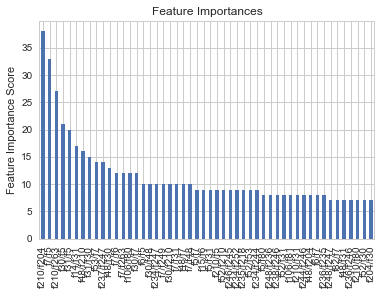

In [7]:
DivideFeatureFromXgboost_importance_list = DivideFeatureFromXgboost(xgb,train,feature_importance_list)

In [8]:
def MultiplyFeatureFromXgboost(alg,df,feature_importance_list):
    '''
    xgboost模型中最重要的50个特征值，两两相乘log组合特征
    注意,输入的df为没经过onehot的特征
    :param df:
    :param feature_importance_list:  xgboost输出的重要性top n list
    :return:  画图做出中重要的组合特征,输出模型选择的top n multiplyFeature特征
    '''
    print ("MultiplyFeatureFromXgboost开始：" + current_time())
    cols =  df.columns[1:]
    for index1, feat1 in enumerate(feature_importance_list):
        for index2, feat2 in enumerate(feature_importance_list):
            if (index1 <= index2):
                df[str(feat1 + '*' + feat2)] = np.log10(df[feat1].mul(df[feat2]))
            else:
                pass
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.median(), inplace=True)
    MultiplyFeatureFromXgboost_importance_list = modelfit(alg, df.drop(cols, 1), 'MultiplyFeatureFromXgboost.png')
    print(" MultiplyFeatureFromXgboost_importance_list:")
    print  MultiplyFeatureFromXgboost_importance_list
    print ("MultiplyFeatureFromXgboost结束：" + current_time())
    return MultiplyFeatureFromXgboost_importance_list

MultiplyFeatureFromXgboost开始：2018-05-22 10:02:17


D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
D:\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


modelfit开始：2018-05-22 10:03:12
[0]	validation_0-auc:0.889822
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.896028
[2]	validation_0-auc:0.897048
[3]	validation_0-auc:0.908192
[4]	validation_0-auc:0.908855
[5]	validation_0-auc:0.909138
[6]	validation_0-auc:0.909303
[7]	validation_0-auc:0.909639
[8]	validation_0-auc:0.914618
[9]	validation_0-auc:0.918465
[10]	validation_0-auc:0.920326
[11]	validation_0-auc:0.922201
[12]	validation_0-auc:0.921863
[13]	validation_0-auc:0.926237
[14]	validation_0-auc:0.926277
[15]	validation_0-auc:0.92636
[16]	validation_0-auc:0.927321
[17]	validation_0-auc:0.927623
[18]	validation_0-auc:0.934201
[19]	validation_0-auc:0.940738
[20]	validation_0-auc:0.939953
[21]	validation_0-auc:0.940297
[22]	validation_0-auc:0.94049
[23]	validation_0-auc:0.940682
[24]	validation_0-auc:0.940891
[25]	validation_0-auc:0.940922
[26]	validation_0-auc:0.940937
[27]	validation_0-auc:0.944041
[28]	validation_0-auc:0.944691
[29]	validation_0-

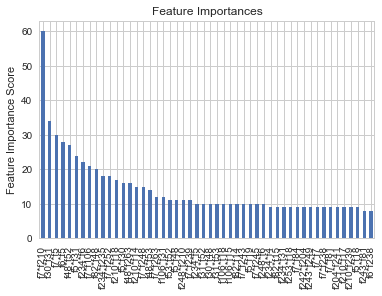

In [9]:
MultiplyFeatureFromXgboost_importance_list = MultiplyFeatureFromXgboost(xgb,train,feature_importance_list)